In [82]:
import pandas as pd
import os
import seaborn as sns

In [2]:
os.chdir(r'C:\Users\Min\Documents\Python Scripts\포트폴리오수업\프로젝트 3. Home Credit 대출상환여부 예측\data')

In [87]:
#pd.read_excel('칼럼정의.xlsx')

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
lb=pd.read_csv('loan_before.csv')

In [4]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

각각의 행이 각각의 사람을 의미한 sk_id-curr는 각사람에게 유니크한 아이디를 붙인거라 생각하면 된다    
target 값은 사람이 빚을 갚았는지 못갚았는지(1)를 의미한다.  
0 여성 1남자  
flag_own_car0 차없음 1 차있음  
amt_credit 대출금액  
지역의 인구를 스케일링(정규화, 수치적인 변화)를 준다 너무 단위가 커서 1000만으로 나눈 값을 쓴다든가 하는 것을 정규화 한다고 한다.  
ext_source_1,2,3 변수는 외부데이터로부터 나온 신용점수 (캐글에서도 딱히 정확한 설명을 하지 않은 데이터)

In [5]:
lb.columns

Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'CREDIT_TYPE'],
      dtype='object')

사람이 예전에 대출을 받았는지 받았다면 갚았는지를 알아보는 것   
lb데이터 프레임에서는 sk_id_curr이 같은 값이 중복하여 나타날 수 있다  
lb는 대출을 받은 것에 대한 기록을 하는 데이터 프레임이므로   

# 문제 정의
 + 현재 코로나로 인해 자영업자들이 생계를 위해 대출을 받아야하는 안타까운 상황이 많이 일어난다 
 + 조금이나마 자영업자들이 생계를 위해 대출을 쉽게 받을 수 있도록 어떤 것들을 신경 써야하는지 알고싶어 분석하게 되었다.
 + <strong>Q1.</strong> 어떤 요소가 대출금 상환 여부에 큰 영향을 미치는 것일까?
 + <strong>Q2.</strong> 각 요소들이 대출금 상환여무에 각각 어떤 영향을 줄까? 
 
# 데이터 출처 : Kaggle Home Credit Defult Risk 대회
  + Home Credit 회사가 제공하는 데이터 대출받은 사람의 인적정보 및 결과 

# 방법론 
## 2.1 분석과정  

이 질문에 대한 해답을 얻기 위해서 해석가능한 머신러닝(xAI)를 활용하였다. 

<strong> 프로세스 </strong>  

1단계 : feature engineering을 한다.  
2단계 : 머신러닝 모델을 만든다.  
3단계 : shap value를 통해 어떤 변수가 가장 예리한 영향을 주는지 알아본다.  
4단계 : 영향을 많이 주는 변수들과 대출금 상환 여부와의 관계를 알아본다.  


## 2.2 feature engineering (변수만들기)

AMT_CREDIT에서 AMT_ANNUITY를 나누어 해당 사람이 먗 개월에 걸쳐 돈을 갚아야 하는지를 변수화 함

In [5]:
# 총 대출 금액을 의미하는 amt_credit을 1달마다 갚아야하는 금액인 amt_annuity로 나누면 대출을 갚아야하는 기간이 나오게 된다.
train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR
0,162716,0,0.0,0,1,0,101250.0,480060.0,22509.0,Unaccompanied,...,-2256,NaN,2.0,15,Kindergarten,NaN,0.665732,NaN,-139.0,1.0
1,361317,0,0.0,0,1,2,225000.0,237024.0,12231.0,Unaccompanied,...,-4133,NaN,4.0,3,Business Entity Type 3,0.575699,0.535140,0.670652,-957.0,0.0
2,246925,0,1.0,0,0,0,171000.0,247675.5,26005.5,Unaccompanied,...,-4340,NaN,2.0,10,Business Entity Type 3,0.092273,0.002272,0.154744,-827.0,1.0
3,294331,0,1.0,1,0,0,225000.0,180000.0,9000.0,Unaccompanied,...,-1621,12.0,2.0,12,Trade: type 7,0.221815,0.120444,NaN,-569.0,2.0
4,152173,0,0.0,0,1,0,180000.0,337500.0,12852.0,Unaccompanied,...,-2870,NaN,1.0,12,XNA,NaN,0.722415,0.723837,-1544.0,4.0


### 사람들이 대출을 갚아야할 기한을 칼럼으로 만들어보자

In [6]:
train['AMT_CREDIT_RATIO']=train['AMT_CREDIT']/train['AMT_ANNUITY']
test['AMT_CREDIT_RATIO']=test['AMT_CREDIT']/test['AMT_ANNUITY']

In [7]:
lb

,SK_ID_CURR,DAYS_CREDIT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,CREDIT_TYPE
0,400486,-2413,0,180000.0,Consumer credit
1,400486,-941,0,40500.0,Credit card
2,400486,-1110,0,114727.5,Consumer credit
3,400486,-2133,0,225000.0,Consumer credit
4,400486,-391,0,142290.0,Consumer credit
...,...,...,...,...,...
142755,375755,-1335,0,195408.0,Consumer credit
142756,375755,-2648,0,202500.0,Credit card
142757,259355,-44,0,11250.0,other
142758,246829,-1878,0,36000.0,Consumer credit


400486 이라는 사람이 중복해서 나오고 있다 왜 일까? 400486이라는 사람이 이전에 대출을 여러번 하였기 때문이다. 가령 10번의 대출을 했다면 400486은 총 10번의 대출을 했다는 것이고 그 각각의 대출의 행위가 lb에 별개의 값으로 입력되었다는 의미이다.

### 사람들이 평균적으로 얼마를 대출 받는가? 변수로 만들어보기

lb(home credit 대출 이전에 대출한 정보가 기록된 데이터프레임)를 활용해 변수생성 시도 <br>

<strong>1. groupby 후 평균 (즉, 사람 id로 묶은 후 각 변수를 평균을 낸다)</strong> <br>
  - AMT_CREDIT_SUM (이전 대출의 금액) <br>
  - DAYS_CREDIT (train,test로부터 며칠 전에 home credit 대출 전에 대출을 받았는가) <br>
  - CNT_CREDIT_PROLONG(대출 연장을 몇 번 했는가)<br>
 
<strong>2. groupby 후 갯수(사람 id의 빈도수 = 대출을 받은 횟수    ※lb데이터 프레임의 특성상)</strong>

In [8]:
# 각각의 사람들이 받은  대출의  평균 금액
a=lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index()
a
# groupby연산뒤에 .reset_index()만 붙여주면 바로 데이터 프레임화가 된다!!

,SK_ID_CURR,AMT_CREDIT_SUM
0,100026,1.875000e+06
1,100041,6.325424e+04
2,100084,9.810000e+04
3,100088,3.555000e+05
4,100100,6.327487e+05
...,...,...
25707,456153,1.627073e+05
25708,456212,2.726224e+05
25709,456238,1.849170e+05
25710,456253,9.900000e+05


In [9]:
train = pd.merge(train,a,on='SK_ID_CURR',how='left')
train

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_RATIO,AMT_CREDIT_SUM
0,162716,0,0.0,0,1,0,101250.0,480060.0,22509.0,Unaccompanied,...,2.0,15,Kindergarten,NaN,0.665732,NaN,-139.0,1.0,21.327469,3.150000e+05
1,361317,0,0.0,0,1,2,225000.0,237024.0,12231.0,Unaccompanied,...,4.0,3,Business Entity Type 3,0.575699,0.535140,0.670652,-957.0,0.0,19.378955,2.067966e+06
2,246925,0,1.0,0,0,0,171000.0,247675.5,26005.5,Unaccompanied,...,2.0,10,Business Entity Type 3,0.092273,0.002272,0.154744,-827.0,1.0,9.523966,6.219386e+04
3,294331,0,1.0,1,0,0,225000.0,180000.0,9000.0,Unaccompanied,...,2.0,12,Trade: type 7,0.221815,0.120444,NaN,-569.0,2.0,20.000000,2.770443e+04
4,152173,0,0.0,0,1,0,180000.0,337500.0,12852.0,Unaccompanied,...,1.0,12,XNA,NaN,0.722415,0.723837,-1544.0,4.0,26.260504,1.068750e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,151299,0,1.0,1,1,0,202500.0,323460.0,25159.5,Unaccompanied,...,2.0,13,Police,0.506455,0.598495,0.134265,-596.0,0.0,12.856376,5.992780e+05
19996,126098,0,0.0,0,1,0,157500.0,225000.0,13045.5,Unaccompanied,...,1.0,11,XNA,NaN,0.668554,0.347418,-521.0,1.0,17.247327,1.253187e+05
19997,344354,0,0.0,0,1,0,112500.0,835380.0,35523.0,Unaccompanied,...,1.0,5,Medicine,0.377091,0.022553,NaN,-1.0,NaN,23.516595,NaN
19998,443567,0,0.0,1,0,0,76500.0,247500.0,12375.0,Unaccompanied,...,2.0,14,Self-employed,0.817025,0.702307,0.102782,-386.0,1.0,20.000000,2.341887e+04


### Home Credit 대출 이전에 사람들은 평균 몇번의 대출을 받아왔는가?

In [10]:
train = pd.merge(train,lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),on='SK_ID_CURR',how='left')
test = pd.merge(test,lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),on='SK_ID_CURR',how='left')

### 사람들은 평균적으로 대출 연장을 몇 번이나 했는가? 

In [11]:
train = pd.merge(train,lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),on='SK_ID_CURR',how='left')
test = pd.merge(test,lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),on='SK_ID_CURR',how='left')

In [12]:
lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'COUNT'})

# 그룹바이되는 것의 중복값이 몇개인지를 알수 있다 즉, 총 몇번 대출을 받았는지를 알 수있다.

,SK_ID_CURR,COUNT
0,100026,3
1,100041,13
2,100084,1
3,100088,5
4,100100,5
...,...,...
25707,456153,14
25708,456212,4
25709,456238,6
25710,456253,4


In [13]:
train = pd.merge(train,lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'COUNT'}),on='SK_ID_CURR',how='left')

In [14]:
# test 데이터도 train 데이터와 똑같은 형태를 해줘야하므로 똑같이 merge해준다.
test = pd.merge(test,lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'COUNT'}),on='SK_ID_CURR',how='left')

### 불필요한 칼럼을 제거하기

해당 프로젝트의 목적은 모델 해석이기 때문에 이에 방해되는 변수는 삭제한다<br>

<strong> 제거한 변수목록</strong>

1. 범주형이라서 지운 변수 
<ul>
<li> CODE_GENDER </li>
  <li> FLAG_OWN_CAR </li>
  <li> NAME_TYPE_SUITE </li>
  <li> NAME_INCOME_TYPE </li>
  <li> NAME_EDUCATION_TYPE </li>
  <li> NAME_HOUSING_TYPE</li>
  <li> ORGANIZATION_TYPE  </li>
</ul> 
<p></p>
2. 의미를 정확히 몰라서 지운 변수  
   - EXT_SOURCE_1
   - EXT_SOURCE_2
   - EXT_SOURCE_3


In [15]:
#우리는 예측이 아닌 모델 해석을 하는것이 주 목적이므로 해석을 하는 것에 불필요한 칼럼을 제거하겠다.
train.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_RATIO', 'AMT_CREDIT_SUM',
       'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'COUNT'],
      dtype='object')

In [16]:
train.dtypes
#CODE_GENDER,FLAG_OWN_CAR 등은 수치형 처럼 보이지만 범주형 데이터이다.

SK_ID_CURR                      int64
TARGET                          int64
CODE_GENDER                   float64
FLAG_OWN_CAR                    int64
FLAG_OWN_REALTY                 int64
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                 float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
CNT_FAM_MEMBERS               float64
HOUR_APPR_PROCESS_START         int64
ORGANIZATION_TYPE              object
EXT_SOURCE_1                  float64
EXT_SOURCE_2                  float64
EXT_SOURCE_3                  float64
DAYS_LAST_PHONE_CHANGE        float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
AMT_CREDIT_R

In [17]:
#범주형 데이터를 지워주자
del_list1=['CODE_GENDER','FLAG_OWN_CAR','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','ORGANIZATION_TYPE']

In [18]:
#범주형은 아니지만 정확히 모르는 칼럼도 삭제해준다
del_list2=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

In [19]:
train = train.drop(del_list1+del_list2,axis=1) #열을 지우는 것이므로 반드시 axis=1로 해줘야 한다.

In [20]:
train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
FLAG_OWN_REALTY                 int64
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                 float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
CNT_FAM_MEMBERS               float64
HOUR_APPR_PROCESS_START         int64
DAYS_LAST_PHONE_CHANGE        float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
AMT_CREDIT_RATIO              float64
AMT_CREDIT_SUM                float64
DAYS_CREDIT                   float64
CNT_CREDIT_PROLONG            float64
COUNT                         float64
dtype: object

In [22]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_RATIO', 'AMT_CREDIT_SUM',
       'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'COUNT'],
      dtype='object')

## 모델링

<strong>모델링을 하기 전, 서로 상관관계가 높은 input 변수를 삭제한다.</strong> <br>
why?? : input 변수가 높은 상관성을 띌 때 shap value는 제대로 된 설명력을 발휘하지 못하기 때문이다.

<strong>how?</strong> <br>
상관관계가 있는 input 변수들 중 TARGET과의 관계가 낮은 것들을 지워주면 된다.

In [24]:
input_var=['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_RATIO', 'AMT_CREDIT_SUM',
       'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'COUNT']

train 데이터 프레임에서 input할 변수들끼리의 관계정도를 알기 위해 .corr()를 실행해 준다.

In [27]:
#데이터프레임[칼럼명들].corr() 
train[input_var].corr()
# 상관계수가 구해진다

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,COUNT
FLAG_OWN_REALTY,1.000000,0.008244,0.003243,-0.042446,-0.001448,0.010826,-0.110930,-0.015164,0.004217,0.019393,0.014595,-0.105580,0.026066,0.090058,-0.083920,-0.002745,0.000174,-0.009790,0.008414
CNT_CHILDREN,0.008244,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.002649
AMT_INCOME_TOTAL,0.003243,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.116635
AMT_CREDIT,-0.042446,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.046902
AMT_ANNUITY,-0.001448,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.013588
REGION_POPULATION_RELATIVE,0.010826,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,-0.034289
DAYS_BIRTH,-0.110930,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,-0.063004
DAYS_EMPLOYED,-0.015164,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.148704
DAYS_ID_PUBLISH,0.004217,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,-0.100673
OWN_CAR_AGE,0.019393,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.025711


숫자들을 눈으로 보는 것 보다는 시각화를 통해 한눈에 알아보자

In [30]:
corr=train[input_var].corr()
corr.style.background_gradient(cmap='coolwarm')

# 붉은 색일 수록 강한 상관계수를 가지게 된다.

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,COUNT
FLAG_OWN_REALTY,1.000000,0.008244,0.003243,-0.042446,-0.001448,0.010826,-0.110930,-0.015164,0.004217,0.019393,0.014595,-0.105580,0.026066,0.090058,-0.083920,-0.002745,0.000174,-0.009790,0.008414
CNT_CHILDREN,0.008244,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.002649
AMT_INCOME_TOTAL,0.003243,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.116635
AMT_CREDIT,-0.042446,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.046902
AMT_ANNUITY,-0.001448,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.013588
REGION_POPULATION_RELATIVE,0.010826,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,-0.034289
DAYS_BIRTH,-0.110930,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,-0.063004
DAYS_EMPLOYED,-0.015164,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.148704
DAYS_ID_PUBLISH,0.004217,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,-0.100673
OWN_CAR_AGE,0.019393,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.025711


시각화 결과 높은 상관성을 띄는 변수는 다음과 같다
<ul>
    <li>CNT_FAM_MEMBERS , CNT_CHILDREN</li>
    <li>AMT_CREDIT_RATIO, AMT_CREDIT</li>
    <li>AMT_ANNUITY, AMT_CREDIT</li>
</ul>

In [31]:
#타겟 값과의 상관계수를 기준으로 변수를 골라낸다.
train['CNT_FAM_MEMBERS'].corr(train['TARGET'])

0.018876651698723837

In [32]:
train['CNT_CHILDREN'].corr(train['TARGET'])

0.025357359317615766

'CNT_CHILDREN'이 'CNT_FAM_MEMBERS'보다 TARGET값과 더 깊은 상관관계를 가지고 있다는 뜻이다.   
상관성이 높은 여러개의 변수들 중 그나마 더 목표값과 관계가 있는 변수만을 추려내기 위해 위 과정을 거쳤고   
상대적으로 낮은 상관계수를 가지고 있는 값은 제거하였다.

In [33]:
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

In [43]:
print(train['AMT_CREDIT_RATIO'].corr(train['TARGET']))
print(train['AMT_CREDIT'].corr(train['TARGET']))

#상관계수의 절댓값이 AMT_CREDIT_RATIO가 더 크므로 AMT_CREDIT을 지워준다.

-0.024740288335190198
-0.022558430849347767


In [44]:
del train['AMT_CREDIT']
del test['AMT_CREDIT']

'AMT_CREDIT'이 삭제 되었으므로  AMT_ANNUITY, AMT_CREDIT의 상관계수 비교는 할 필요가 없다  

<ul>
  <상관관계를 파악하는데 사용될 변수들>
    <li>'CNT_CHILDREN'</li>
    <li>'AMT_CREDIT_RATIO'</li>
    <li>AMT_ANNUITY</li>
</ul>

In [53]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_RATIO', 'AMT_CREDIT_SUM',
       'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'COUNT'],
      dtype='object')

In [54]:
input_var=['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_RATIO', 'AMT_CREDIT_SUM',
       'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'COUNT']

<strong>xgboost를 활용한 모델링</strong> <br>
shap value를 활용하기 위해선 모델이 RandomForest 형태의 tree형 모델이어야 한다. 이 중에서 xgbosst가 속도가 빠르면서 높은 성능을 유지하므로 이를 선택 하였다

In [55]:
from xgboost import XGBClassifier

In [57]:
model = XGBClassifier(n_estimators=100, learning_rate=0.1)
model.fit(train[input_var],train['TARGET'])

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## shap value 활용하기

In [62]:
#!pip install shap

In [59]:
import shap

In [60]:
shap_values = shap.TreeExplainer(model).shap_values(train[input_var])
shap_values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


array([[ 0.00223432, -0.00216155, -0.05633333, ...,  0.58048975,
        -0.00708694, -0.15232365],
       [ 0.00239432,  0.0078953 , -0.08278084, ..., -0.37153658,
        -0.00582932,  0.13379753],
       [-0.00555511, -0.06731942,  0.06166759, ...,  0.06139689,
        -0.0086683 ,  0.05538433],
       ...,
       [ 0.00365143,  0.00299184, -0.02941138, ...,  0.1624478 ,
         0.01325237, -0.01982869],
       [-0.00680675, -0.00236461,  0.01851846, ..., -0.16202965,
        -0.00248337, -0.05653656],
       [ 0.00157603, -0.00361163,  0.04432501, ...,  0.20997503,
        -0.01184627, -0.11149307]], dtype=float32)

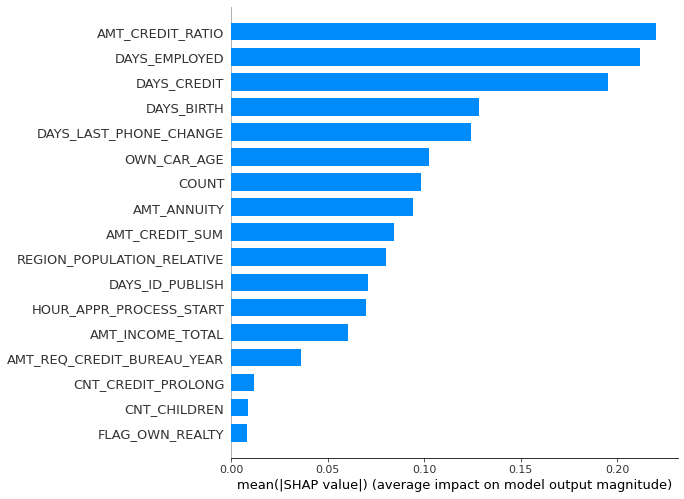

In [61]:
shap.summary_plot(shap_values,train[input_var],plot_type='bar')

시각화 결과, 타겟값에 가장 큰 영향을 미치는 상위 5가지 변수는 아래와 같다.,
<ul>
    <li>AMT_CREDIT_RATIO</li>
    <li>DAYS_EMPLOYED</li>
    <li>DAYS_CREDIT</li>
    <li>DAYS_BIRTH</li>
    <li>DAYS_LAST_PHONE_CHANGE</li>

</ul>


## 영향을 많이 주는 5개의 변수와 상환여부와의 관계를 알아보자

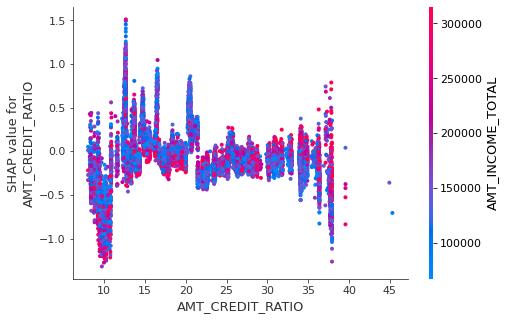

In [65]:
shap.dependence_plot('AMT_CREDIT_RATIO',shap_values,train[input_var])

대출 상환 기간이 12개월에서 20개월 사이일 떄 비교적 상환을 잘못한다는 것을 알 수 있다.
반면 12개월 이하, 20개월 이상일 때는 상환을 비교적 잘한다. 
(Target 0: 정상상환, Target 1: 상환 못함) ( 즉, 값이 작을 수록 상환을 잘 한다는 뜻이므로)

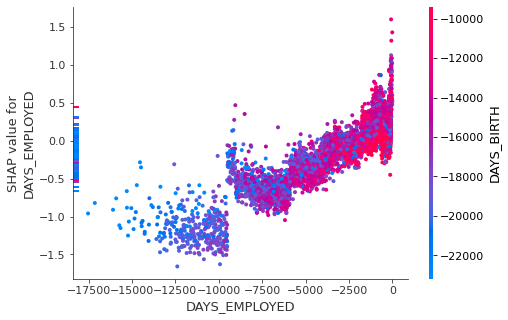

In [66]:
shap.dependence_plot('DAYS_EMPLOYED',shap_values,train[input_var])

-값이 클수록 취업한지 오래 되었다는 뜻으로 취업한지 오래 될수록 대출 상환할 가능성이 높다고 보면 된다.<br>
대출일 기준 9000일보다 오래전에 취업했을 때 대출상환능력이 급상승한다.

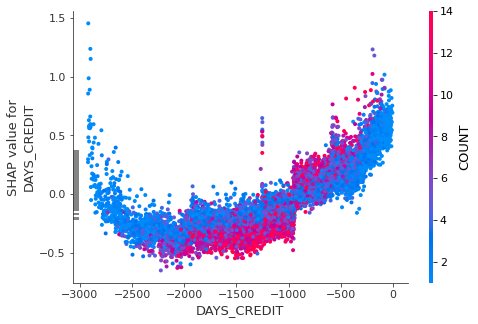

In [67]:
shap.dependence_plot('DAYS_CREDIT',shap_values,train[input_var])

DAYS_CREDIT은 -3000일부터 -2000일까지는 대출상환능력이 상승하지만 그 이후부터는 오히려 떨어진다.  
<strong>비선형 관계를 나타내고 있다.</strong>

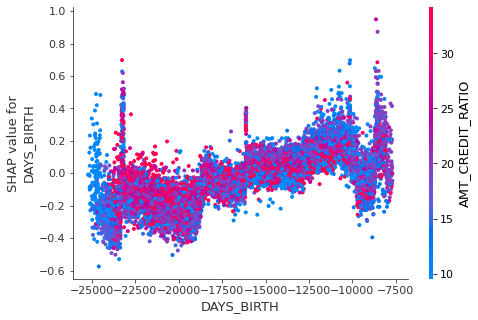

In [69]:
shap.dependence_plot('DAYS_BIRTH',shap_values,train[input_var])

대출 일로부터 오래전에 태어났다면 즉, 나이가 많을 수록 대출 상환할 확률이 올라간다는 것을 알 수 있다.

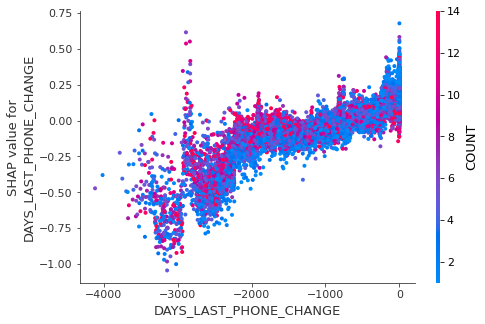

In [68]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE',shap_values,train[input_var])

대출하는 날 기준으로 오래전에 핸드폰을 바꿨을수록 대출금 상환확률이 올라간다는 것을 알 수 있다.

## 결론
1. 대출 상환 기간이 상환여부에 가장 큰 영향을 준다는 것을 알 수 있었다.해당 영향은 비선형적 관계이다.  
    (영향이 크다고 해서 인과관계가 있다고 단정짓긴 어렵다)<p>
    
2. 주택 보유 여부와 자식의 수는 대출 상환능력에 큰 영향을 미치지 않았다.  <p>

3. 최근에 취업앴을 수록, 최근에 대출을 받을 수록, 최근에 핸드폰을 바꿀수록, 나이가 어릴 수록 대출금 상환 가능성이 낮아진다.
   (DAYS_EMPLOYED,DAYS_CREDIT,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE가 클 수록 대출금 상환 가능성이 낮아진다.)

### 마무리 시각화하기

.quntile(0.75): 데이터 프레임에서 값이 상위 25프로인 값을 가지고 오라는 뜻<br>
그렇다면 상위 10%를 가지고 오고 싶다면 어떻게 하면 될까? .quantile(0.9)  
하위 25%를 가지고 오고 싶다면? .quantile(0.25)

In [71]:
train.loc[(train['DAYS_EMPLOYED'].quantile(0.75)<train['DAYS_EMPLOYED'])] #상위 25%보다 큰 값을 가지고 오게 된디.

,SK_ID_CURR,TARGET,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,COUNT
5,124950,0,0,0,292500.0,43429.5,0.006207,-14803,-106.0,-1791,18.0,13,-771.0,NaN,20.723241,NaN,NaN,NaN,NaN
10,374768,0,1,0,180000.0,39460.5,0.035792,-23409,-321.0,-4236,7.0,11,-2561.0,1.0,21.508724,156211.550000,-1119.555556,0.0,9.0
12,420387,0,1,1,135000.0,20250.0,0.046220,-14889,-207.0,-4572,3.0,18,-1118.0,0.0,20.000000,418342.000000,-1209.000000,0.0,9.0
19,148243,0,1,0,157500.0,29470.5,0.006305,-9946,-694.0,-430,NaN,9,0.0,7.0,20.787296,670500.000000,-291.000000,0.0,1.0
25,372587,0,0,0,157500.0,13500.0,0.031329,-15148,-590.0,-2459,2.0,12,0.0,2.0,20.000000,18153.000000,-390.500000,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,377014,0,0,1,112500.0,17019.0,0.035792,-12669,-426.0,-4386,NaN,14,-1492.0,1.0,26.326811,63060.187500,-1996.750000,0.0,8.0
19988,408244,1,1,0,382500.0,26446.5,0.022625,-18957,-399.0,-2456,NaN,10,-2216.0,1.0,34.030968,607842.759375,-1238.500000,0.0,8.0
19989,407762,0,0,0,427500.0,45954.0,0.046220,-11697,-268.0,-1763,NaN,16,-543.0,3.0,19.584802,135738.843750,-1026.250000,0.0,4.0
19990,336173,0,1,1,67500.0,9000.0,0.035792,-16394,-198.0,-1420,NaN,15,-2011.0,0.0,20.000000,652603.500000,-1932.000000,0.0,2.0


In [74]:
group1 = train.loc[(train['DAYS_EMPLOYED'].quantile(0.75)<train['DAYS_EMPLOYED'])&
                   (train['DAYS_CREDIT'].quantile(0.75)<train['DAYS_CREDIT'])&
                   (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75)<train['DAYS_LAST_PHONE_CHANGE'])&
                   (train['DAYS_BIRTH'].quantile(0.75)<train['DAYS_BIRTH'])]

In [75]:
group2 = train.loc[(train['DAYS_EMPLOYED'].quantile(0.25)>train['DAYS_EMPLOYED'])&
                   (train['DAYS_CREDIT'].quantile(0.25)>train['DAYS_CREDIT'])&
                   (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.25)>train['DAYS_LAST_PHONE_CHANGE'])&
                   (train['DAYS_BIRTH'].quantile(0.25)>train['DAYS_BIRTH'])]

In [76]:
group1['group']=1
group2['group']=0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [78]:
full = pd.concat([group1,group2],axis=0)
full

,SK_ID_CURR,TARGET,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,COUNT,group
19,148243,0,1,0,157500.0,29470.5,0.006305,-9946,-694.0,-430,NaN,9,0.0,7.0,20.787296,670500.000000,-291.000000,0.0,1.0,1
97,449339,0,1,0,139500.0,22122.0,0.018801,-8723,-263.0,-1404,13.0,8,-256.0,1.0,24.410090,402856.500000,-449.666667,0.0,6.0,1
104,244014,0,1,0,103500.0,14715.0,0.007020,-12172,-634.0,-2351,NaN,14,-5.0,0.0,31.854128,205537.500000,-345.500000,0.0,2.0,1
130,213561,0,1,2,220500.0,17311.5,0.016612,-10021,-180.0,-2699,20.0,12,-118.0,0.0,26.254224,90000.000000,-204.000000,0.0,1.0,1
187,132571,0,1,0,112500.0,18927.0,0.018029,-9361,-631.0,-2038,NaN,6,-118.0,2.0,21.305516,119263.500000,-374.250000,0.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18513,350380,0,1,0,157500.0,30645.0,0.046220,-20285,-6106.0,-3830,9.0,17,-2197.0,3.0,25.110132,104065.200000,-1597.500000,0.0,2.0,0
18617,169817,0,1,0,270000.0,30640.5,0.024610,-20163,-8222.0,-3667,NaN,12,-1812.0,3.0,27.840799,105273.125000,-1713.888889,0.0,18.0,0
19773,357658,0,0,0,135000.0,22216.5,0.007305,-19808,-3285.0,-3307,NaN,8,-2459.0,0.0,23.463642,443457.500000,-1568.333333,0.0,9.0,0
19783,255934,0,0,0,382500.0,24403.5,0.025164,-20340,-6993.0,-3798,2.0,16,-1692.0,1.0,34.020284,157494.353226,-1819.451613,0.0,31.0,0


<AxesSubplot:xlabel='group', ylabel='TARGET'>

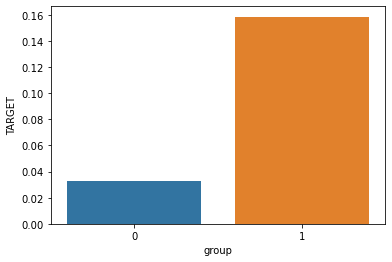

In [85]:
sns.barplot(data=full,x='group',y='TARGET',ci=False)